In [234]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Часть 1

#### Get books html elements

In [235]:
base_url = "https://www.litres.ru/genre/programmirovanie-5272/?page={}"

books = []
books_count = 40
page = 1

while len(books) < books_count:
    url = base_url.format(page)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    books_on_page = soup.find_all('div', class_=re.compile(r'ArtDefault_container'))

    remaining_books = books_count - len(books)
    books.extend(books_on_page[:remaining_books])

    page += 1
    time.sleep(1)

In [236]:
def clean_html(raw_html: str) -> str:
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text()


def get_reviews(book_id: str):
    url = f"https://api.litres.ru/foundation/api/arts/{book_id}/reviews"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        if data["status"] == 200 and "data" in data["payload"]:
            reviews = data["payload"]["data"]
            review_texts = [clean_html(review["text"]) for review in reviews]
            return review_texts
        else:
            print("No reviews found or incorrect response structure.")
            return []
    else:
        print(f"Failed to retrieve reviews. Status code: {response.status_code}")
        return []

In [237]:
def parse_book_id(url: str) -> str:
    book_id = url.rstrip('/').split('-')[-1]
    return book_id


def get_book_html(book_url: str):
    response = requests.get(book_url)
    soup = BeautifulSoup(response.text, "html.parser")

    review_div = soup.find('div', {'data-testid': 'book-factoids__reviews'}).text.strip()
    review_count = int(re.search(r'\d+', review_div).group()) if review_div else 0

    details_div = soup.find('div', {'data-testid': 'book-volume__wrapper'}).text.strip()
    pages_count_match = re.search(r'Объем\s(\d+)\sстраниц', details_div)
    pages_count = int(pages_count_match.group(1)) if pages_count_match else 0

    year_match = re.search(r'(\d{4})\sгод', details_div)
    year = int(year_match.group(1)) if year_match else 0

    age_match = re.search(r'(\d+)\+', details_div)
    age = int(age_match.group(1)) if age_match else 0

    id = parse_book_id(book_url)
    text_reviews = get_reviews(id)
    time.sleep(1)

    return review_count, pages_count, text_reviews, age, year

#### Fetch books data

In [238]:
data = []

for book in books:
    name = book.find('a', {'data-testid': 'art__title'}).text.strip()

    author = book.find('a', {'data-testid': 'art__authorName'}).text.strip()

    link = book.find('div', {'data-testid': 'art__cover'})
    full_link = f"https://www.litres.ru{link.find('a')['href']}"

    rating_div = book.find('div', {'data-testid': 'art__ratingAvg'}).text.strip()
    rating = float(rating_div.replace(',', '.'))

    rating_count_div = book.find('div', {'data-testid': 'art__ratingCount'})
    rating_count = int(rating_count_div.text) if rating_count_div else 0

    price_text = book.find('strong', {'data-testid': 'art_price--value'}).text.strip()
    price = int(re.sub(r'\D', '', price_text))

    review_count, pages_count, text_reviews, age, year = get_book_html(full_link)

    data.append({
        'name': name,
        'author': author,
        'link': full_link,
        'rating': rating,
        'rating_count': rating_count,
        'review_count': review_count,
        'pages_count': pages_count,
        'text_reviews': text_reviews,
        'price': price,
        'age': age,
        'year': year,
    })

In [239]:
df = pd.DataFrame(data)
df.head()

,name,author,link,rating,rating_count,review_count,pages_count,text_reviews,price,age,year
0,Начинаем программировать на Python,Тони Гэддис,https://www.litres.ru/book/toni-geddis-3249116...,4.9,16,6,875,[Шикарная книга! Начал изучать Python самостоя...,599,12,2021
1,System Design. Подготовка к сложному интервью,Алекс Сюй,https://www.litres.ru/book/aleks-suy/system-de...,3.6,17,9,304,[Добротная книга по разработке архитектуры при...,699,16,2020
2,Изучаем DDD – предметно-ориентированное проект...,Влад Хононов,https://www.litres.ru/book/vlad-hononov/izucha...,0.0,0,1,319,"[Эта книга из той лиги, в которой я пока не со...",549,0,2022
3,Высоконагруженные приложения. Программирование...,Мартин Клеппман,https://www.litres.ru/book/martin-kleppman-173...,4.0,51,11,640,"[Не могу что-либо про перевод сказать, читал д...",799,16,2017
4,Python Библиотеки,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/pytho...,5.0,339,11,192,[На каждую библиотеку в книге приводится приме...,690,12,2024


## Часть 2

1. Выведите первые 5 строк датасета. (0.25). Сколько в нём строк и столбцов (0.25)?

In [240]:
rows, columns = df.shape
print(f'Строк: {rows}, столбцов: {columns}')

Строк: 40, столбцов: 11


2. Есть ли в датасете пропуски? (0.5)

In [241]:
missing_values = df.isnull().any().any()

if missing_values:
    print('В датасете есть пропущенные значения.')
else:
    print('В датасете нет пропущенных значений.')

В датасете нет пропущенных значений.


3. Проверьте типы данных. Если это необходимо, приведите к типам int и float те столбцы, с которыми понадобится работать как с числами. (1).

In [242]:
df.dtypes

name             object
author           object
link             object
rating          float64
rating_count      int64
review_count      int64
pages_count       int64
text_reviews     object
price             int64
age               int64
year              int64
dtype: object

4. Выведите описательные статистики переменных. Ответьте на следующие вопросы:

* Какая медианная цена книги в вашем датасете? (1)  
* Какое возрастное ограничение встречается чаще всего? (1)  
* Какое среднее число отзывов в книге? (1)  
* Сколько книг имеют оценку ниже 4.25? (1)  
* В каком году было написано больше всего книг из датасета? (1)  

In [243]:
price_median = df['price'].median()
age_mode = df['age'].mode()[0]
mean_reviews_count = df['review_count'].mean()
low_rating_count = df[df['rating'] < 4.25].shape[0]

year_counts = df['year'].value_counts()
most_common_year = year_counts.idxmax()

print(f'Медианная цена книги: {price_median}')
print(f'Самое частое возрастное ограничение: {age_mode}')
print(f'Среднее число отзывов в книге: {mean_reviews_count}')
print(f'Число книг имеют оценку ниже 4.25: {low_rating_count}')
print(f'Больше всего книг в году: {most_common_year}')

Медианная цена книги: 690.0
Самое частое возрастное ограничение: 16
Среднее число отзывов в книге: 5.925
Число книг имеют оценку ниже 4.25: 13
Больше всего книг в году: 2023


5. Если вы работаете с готовым датасетом, то попробуйте "достать" из столбца pages количество страниц. Если у вас не получилось, то далее при определении числа страниц пользуйтесь стольцов pages_count. Если вы парсили датасет сами, то вы получаете балл за этот пункт автоматически (1.5)

In [244]:
df.pages_count

0      875
1      304
2      319
3      640
4      192
5      816
6      102
7      416
8      485
9      259
10     280
11     305
12     272
13     983
14     528
15    1056
16     619
17     903
18     390
19     546
20     448
21     464
22     320
23     242
24     448
25     912
26     211
27     480
28     193
29     323
30     503
31     544
32     608
33       0
34     979
35     275
36    1223
37     642
38     512
39     313
Name: pages_count, dtype: int64

6. Создайте новое поле is_popular. Значение равно 1, если рейтинг книги не менее 4.6 и при этом у нее не менее 5 отзывов, и 0 в остальных случаях. (1)

In [245]:
df['is_popular'] = np.where((df['rating'] >= 4.6) & (df['review_count'] >= 5), 1, 0)
df.head()

,name,author,link,rating,rating_count,review_count,pages_count,text_reviews,price,age,year,is_popular
0,Начинаем программировать на Python,Тони Гэддис,https://www.litres.ru/book/toni-geddis-3249116...,4.9,16,6,875,[Шикарная книга! Начал изучать Python самостоя...,599,12,2021,1
1,System Design. Подготовка к сложному интервью,Алекс Сюй,https://www.litres.ru/book/aleks-suy/system-de...,3.6,17,9,304,[Добротная книга по разработке архитектуры при...,699,16,2020,0
2,Изучаем DDD – предметно-ориентированное проект...,Влад Хононов,https://www.litres.ru/book/vlad-hononov/izucha...,0.0,0,1,319,"[Эта книга из той лиги, в которой я пока не со...",549,0,2022,0
3,Высоконагруженные приложения. Программирование...,Мартин Клеппман,https://www.litres.ru/book/martin-kleppman-173...,4.0,51,11,640,"[Не могу что-либо про перевод сказать, читал д...",799,16,2017,0
4,Python Библиотеки,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/pytho...,5.0,339,11,192,[На каждую библиотеку в книге приводится приме...,690,12,2024,1


7. Как отличается среднее число страниц среди популярных и непопулярных книг? (2)

In [246]:
difference = abs(df[df['is_popular'] == 1]['pages_count'].mean() - df[df['is_popular'] == 0]['pages_count'].mean())

print(f"Разница в среднем числе страниц между популярными и непопулярными книгами: {difference:.2f}")

Разница в среднем числе страниц между популярными и непопулярными книгами: 174.26


8. Выведите топ-10 книг по числу отзывов. (2).

In [247]:
df.sort_values(by='review_count', ascending=False).head(10)

,name,author,link,rating,rating_count,review_count,pages_count,text_reviews,price,age,year,is_popular
6,Нейросети начало,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/neyro...,4.9,433,37,102,[Книга отличная. Давно хотела понять как все р...,690,12,2023,1
23,Сделай видеоигру один и не свихнись,Слава Грис,https://www.litres.ru/book/slava-gris/sdelay-v...,4.7,85,24,242,[Отличная книга для инди-разработчиков! Must r...,499,12,2023,1
21,"Чистый код: создание, анализ и рефакторинг (pd...",Роберт Мартин,https://www.litres.ru/book/robert-s-martin/chi...,4.2,121,19,464,"[Несмотря на то, что некоторые вещи, расмотрен...",599,16,0,0
13,1С:Предприятие 8.3. Практическое пособие разра...,М. Г. Радченко,https://www.litres.ru/book/e-u-hrustaleva/1s-p...,4.5,72,15,983,[Книга супер!!! Даю проверенный совет. Прошла ...,180,12,2023,0
29,Искусственный интеллект. Основные понятия,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/iskus...,5.0,322,11,323,[Мне понравилось понятное и подробное описание...,690,12,2024,1
3,Высоконагруженные приложения. Программирование...,Мартин Клеппман,https://www.litres.ru/book/martin-kleppman-173...,4.0,51,11,640,"[Не могу что-либо про перевод сказать, читал д...",799,16,2017,0
4,Python Библиотеки,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/pytho...,5.0,339,11,192,[На каждую библиотеку в книге приводится приме...,690,12,2024,1
16,Программирование на Python в примерах и задачах,Алексей Васильев,https://www.litres.ru/book/aleksey-nikolaevich...,4.1,26,9,619,[Сырая и не проработанная книга! Мало иллюстра...,549,12,2021,0
1,System Design. Подготовка к сложному интервью,Алекс Сюй,https://www.litres.ru/book/aleks-suy/system-de...,3.6,17,9,304,[Добротная книга по разработке архитектуры при...,699,16,2020,0
10,Создай свой VPN. Безопасное использование инте...,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/sozda...,5.0,240,8,280,[Нашел в книге решение своей ошибки. В общем д...,690,12,2024,1


9. Найдите среднюю длину отзыва (в символах). (2)

In [248]:
def average_review_length(reviews):
    if len(reviews) == 0:
        return 0
    total_length = sum(len(review) for review in reviews)
    return total_length / len(reviews)


# Вычисляем среднюю длину отзыва для каждой книги
df['average_review_length'] = df['text_reviews'].apply(average_review_length)

# Вычисляем среднюю длину отзыва по всем книгам
overall_average_length = df['average_review_length'].mean()

print(f"Средняя длина отзыва по всем книгам: {overall_average_length:.2f} символов")

Средняя длина отзыва по всем книгам: 361.97 символов


10. Постройте таблицу корреляций числовых переменных. (1) Прокомментируйте результаты. (1)

In [249]:
numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

<Axes: >

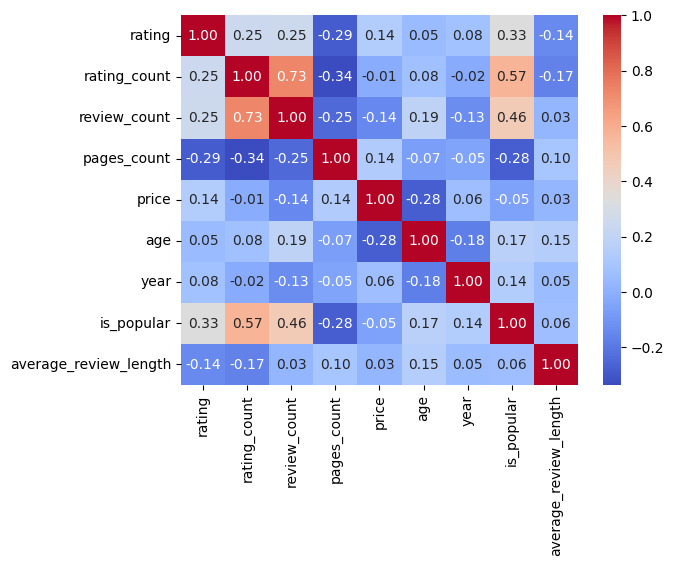

In [250]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

Согласно heatmap наиболее коррелируют между собой следующие параметры:
- Число оценок и число отзывов (положительная корреляция)
- Число оценок и популярность (положительная корреляция)
- Число отзывов и популярность (положительная корреляция, но не такая сильная)

Из забавного есть небольшая отрицательная корреляция между кол-вом страниц и числом оценок =) 

11. Постройте диаграмму рассеяния (scatterplot) количества страниц и количества отзывов. Не забудьте подписать график и оси. (1) Прокомментируйте полученные результаты. (1)

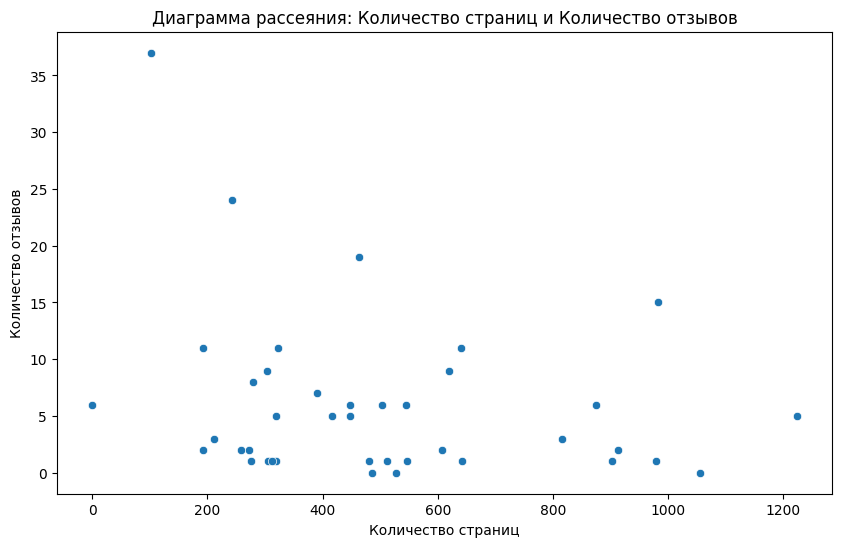

In [251]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pages_count', y='review_count', data=df)

plt.title('Диаграмма рассеяния: Количество страниц и Количество отзывов')
plt.xlabel('Количество страниц')
plt.ylabel('Количество отзывов')

plt.show()

- Большинство книг сосредоточены в диапазоне до 600 страниц и до 10 отзывов.
- Наблюдается некоторая положительная корреляция между количеством страниц и количеством отзывов, но она не является строгой. Это значит, что книги с большим количеством страниц могут получать больше отзывов, но это не правило, и другие факторы могут играть важную роль.

12. Постройте линейный график: по оси Х год, по оси Y количество книг. (1) Прокомментируйте. (1)

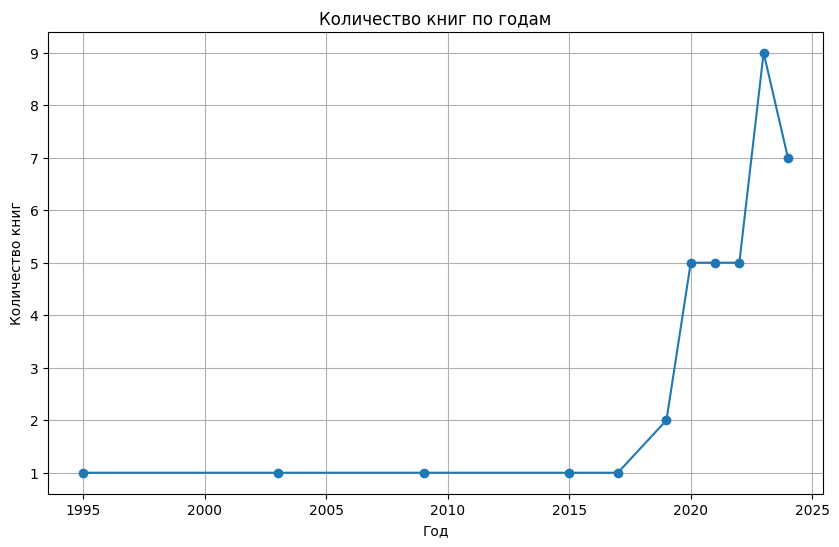

In [252]:
df_filtered = df[df['year'] > 0]
books_per_year = df_filtered.groupby('year').size()

plt.figure(figsize=(10, 6))
books_per_year.plot(kind='line', marker='o')

plt.title('Количество книг по годам')
plt.xlabel('Год')
plt.ylabel('Количество книг')
plt.grid(True)

plt.show()

- До 2015 года стабильно выпускалось по одной книге
- Пик приходится на 2023 год, в 2024 на 2 книги выпущено меньше

12. Постройте еще любые два графика по вашему усмотрению. (2) Прокомментируйте полученные результаты. (1.5)

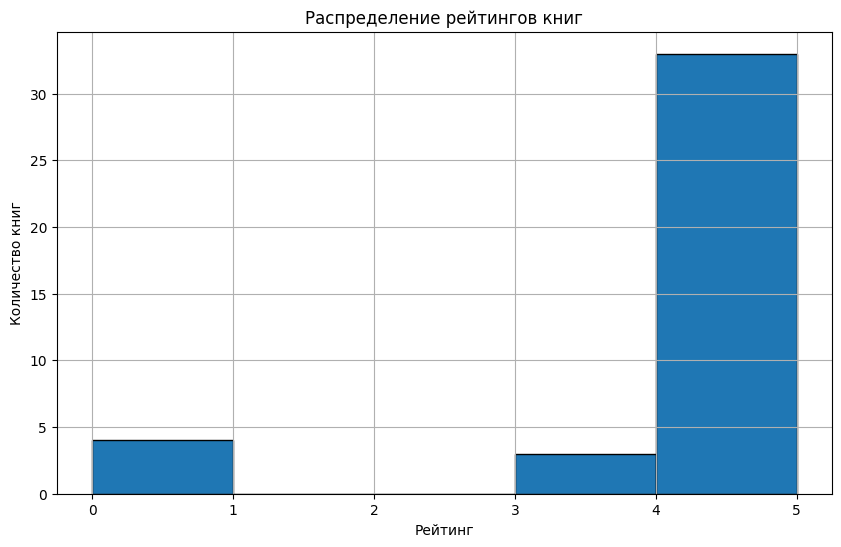

In [253]:
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=5, edgecolor='black')
plt.title('Распределение рейтингов книг')
plt.xlabel('Рейтинг')
plt.ylabel('Количество книг')
plt.grid(True)
plt.show()

Большинство книг имеент оценку 4 и больше

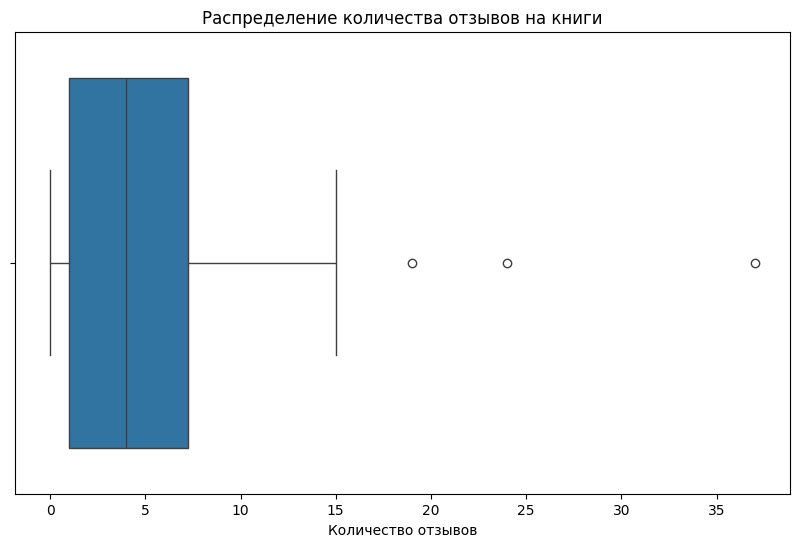

In [254]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['review_count'])
plt.title('Распределение количества отзывов на книги')
plt.xlabel('Количество отзывов')
plt.show()

Большинство книг имеет количество отзывов, сосредоточенное в нижней части шкалы, что говорит о том, что большинство книг в выборке имеют относительно мало отзывов, в то время как несколько книг получили значительно больше внимания.

13. Постройте таблицу с авторами книг с именем автора, количество книг в датасете, средней оценкой книг, средним количеством отзывов. (2).

In [255]:
authors_table = df.groupby('author').agg(
    books_count=('name', 'count'),
    average_rating=('rating', 'mean'),
    average_review_count=('review_count', 'mean')
).reset_index()
print(authors_table)

                        author  books_count  average_rating  \
0                    Алекс Сюй            1        3.600000   
1             Алексей Васильев            1        4.100000   
2                  Анирад Коул            1        5.000000   
3                  Брюс Шнайер            1        4.500000   
4             Бьерн Страуструп            1        4.300000   
5                 Влад Хононов            1        0.000000   
6             Владимир Хориков            1        4.600000   
7                 Д. Е. Турчин            1        5.000000   
8                 Джейд Картер            5        4.980000   
9                  Джон Боднер            1        5.000000   
10                Дон Гриффитс            1        4.300000   
11            Е. Ю. Хрусталева            2        2.300000   
12              Игорь Симдянов            1        4.500000   
13           Коллектив авторов            1        3.000000   
14              Крис Ричардсон            1        4.20

14. Что еще интересного можно увидеть в этом датасете? Просмотрите на данные и ответьте на какие-нибудь вопросы, на которые не ответили в предыдущим пункте. Мы никак не ограничиваем вашу фантазию! (3).

In [256]:
authors_page_count = df.groupby('author').agg(
    average_pages=('pages_count', 'mean')
).reset_index()
authors_page_count = authors_page_count.sort_values(by='average_pages', ascending=False)

print('Какие авторы пишут самые объемные книги?')
print(authors_page_count)

Какие авторы пишут самые объемные книги?
                        author  average_pages
4             Бьерн Страуструп    1223.000000
23                  Пол Дейтел    1056.000000
12              Игорь Симдянов     979.000000
16              М. Г. Радченко     943.000000
10                Дон Гриффитс     912.000000
28                 Тони Гэддис     875.000000
29             Эндрю Таненбаум     816.000000
13           Коллектив авторов     642.000000
17             Мартин Клеппман     640.000000
1             Алексей Васильев     619.000000
2                  Анирад Коул     608.000000
18               Мартин Фаулер     546.000000
14              Крис Ричардсон     544.000000
30                    Эрик Чоу     528.000000
21               Нина Комолова     512.000000
11            Е. Ю. Хрусталева     494.000000
27               Тейва Харшани     480.000000
25               Роберт Мартин     464.000000
20                    Нил Форд     448.000000
24               Ральф Джонсон     448.

In [257]:
df['reviews_to_rating_ratio'] = df['review_count'] / df['rating']
top_discussed_books = df.sort_values(by='reviews_to_rating_ratio', ascending=False).head(10)

print('Какие книги являются самыми обсуждаемыми (имеют наибольшее количество отзывов) по отношению к их рейтингу?')
print(top_discussed_books[['name', 'author', 'rating', 'review_count', 'reviews_to_rating_ratio']])

Какие книги являются самыми обсуждаемыми (имеют наибольшее количество отзывов) по отношению к их рейтингу?
                                                 name           author  \
2   Изучаем DDD – предметно-ориентированное проект...     Влад Хононов   
17  Разработка интерфейса прикладных решений на пл...   М. Г. Радченко   
6                                    Нейросети начало     Джейд Картер   
23                Сделай видеоигру один и не свихнись       Слава Грис   
21  Чистый код: создание, анализ и рефакторинг (pd...    Роберт Мартин   
13  1С:Предприятие 8.3. Практическое пособие разра...   М. Г. Радченко   
3   Высоконагруженные приложения. Программирование...  Мартин Клеппман   
1       System Design. Подготовка к сложному интервью        Алекс Сюй   
4                                   Python Библиотеки     Джейд Картер   
29          Искусственный интеллект. Основные понятия     Джейд Картер   

    rating  review_count  reviews_to_rating_ratio  
2      0.0             1  